In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os, sys

# For bigfiles
from io import TextIOWrapper
from zipfile import ZipFile

import numpy as np

# Color rules (based on https://personal.sron.nl/~pault/)
GREEN = "#117733"
TEAL  = "#44AA99"
CYAN = "#88CCEE"
OLIVE = "#999933"
SAND = "#DDCC77"
ROSE   = "#CC6677"
BLUE = "#88CCEE"
MAGENTA = "#AA4499"
GREY = GRAY = "#DDDDDD"

def set_font(size):
    text_font_size = size
    marker_font_size = size
    label_font_size = size
    axes_font_size = size

    plt.rc('text', usetex=True)
    plt.rc('pdf', use14corefonts=True, fonttype=42)
    plt.rc('ps', useafm=True)
    plt.rc('font', size=text_font_size, weight="bold", family='serif', serif='cm10')
    plt.rc('axes', labelsize=axes_font_size,labelweight="bold")    
    plt.rc('xtick', labelsize=label_font_size)    
    plt.rc('ytick', labelsize=label_font_size)    
    plt.rc('legend', fontsize=label_font_size)  
    plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath} \boldmath"
set_font(21)

def save_plot(name):
    plt.savefig(f'./plots/{name}')

def bold(text):
    return r'\textbf{' + text + r'}'
    
def stdef(vals):
    avg = sum(vals) / len(vals)
    sumderiv = 0;
    for val in vals:
        sumderiv = sumderiv + val * val
    sumderivavg = sumderiv / (len(vals) - 1)
    return math.sqrt(sumderivavg - (avg*avg))


def avg(vals):
    return sum(vals)/len(vals)

In [40]:
def parse_filebench(filename):
    rows = []
    row = -1
    total_seconds = -1
    with open(filename) as fileserver_dat:
        lines = fileserver_dat.readlines()
        for line in lines:
            if 'Per-Operation Breakdown' in line:
                row = {'time':float( (line.split()[0]).split(':')[0]), 'data':{'total':{}}}
            elif 'IO Summary' in line:
                row['data']['total'] = {
                    'count': float(line.split()[3]),
                    'throughput_ops': float(line.split()[5]),
                    'throughput_bytes': float(line.split()[9].split('mb')[0]),
                    'latency_avg': float(line.split()[10].split('ms')[0]),
                }
                rows.append(row)
            elif 'Run took' in line:
                total_seconds = float(line.split()[3])
                break
            elif row != -1:
                value = {
                    'count': float(line.split()[1].split('ops')[0]),
                    'throughput_ops': float(line.split()[2].split('ops')[0]),
                    'throughput_bytes': float(line.split()[3].split('mb')[0]),
                    'latency_avg': float(line.split()[4].split('ms')[0]),
                    'latency_min': float(line.split()[5].split('ms')[0].split('[')[1]),
                    'latency_max': float(line.split()[7].split('ms')[0].split(']')[0]),
                }
                #print(line.split()[0][:-1], value)
                row['data'][line.split()[0][:-1]] = value
    return [total_seconds, rows]

In [45]:
total_seconds_fileserver, rows_fileserver = parse_filebench('results/fileserver-1697195004.out')
total_seconds_varmail, rows_varmail = parse_filebench('results/varmail-1697191563.out')
total_seconds_webserver, rows_webserver = parse_filebench('results/webserver-1697188036.out')


    
print(rows_varmail)

[{'time': 157.572, 'data': {'total': {'count': 22543.0, 'throughput_ops': 4508.214, 'throughput_bytes': 14.9, 'latency_avg': 3.529}, 'closefile': {'count': 1736.0, 'throughput_ops': 347.0, 'throughput_bytes': 0.0, 'latency_avg': 0.007, 'latency_min': 0.001, 'latency_max': 0.055}, 'readfile': {'count': 1732.0, 'throughput_ops': 346.0, 'throughput_bytes': 4.9, 'latency_avg': 1.57, 'latency_min': 0.007, 'latency_max': 25.284}, 'openfile': {'count': 1736.0, 'throughput_ops': 347.0, 'throughput_bytes': 0.0, 'latency_avg': 4.004, 'latency_min': 0.007, 'latency_max': 34.954}, 'fsyncfile': {'count': 1737.0, 'throughput_ops': 347.0, 'throughput_bytes': 0.0, 'latency_avg': 9.9, 'latency_min': 1.683, 'latency_max': 25.631}, 'appendfilerand': {'count': 1741.0, 'throughput_ops': 348.0, 'throughput_bytes': 2.7, 'latency_avg': 0.033, 'latency_min': 0.012, 'latency_max': 5.393}, 'createfile': {'count': 1741.0, 'throughput_ops': 348.0, 'throughput_bytes': 0.0, 'latency_avg': 4.588, 'latency_min': 0.032

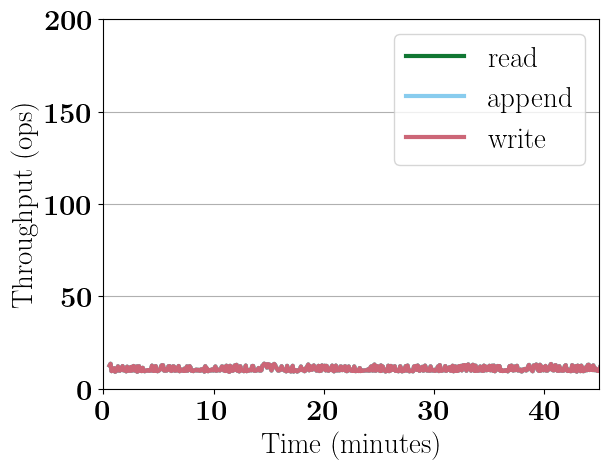

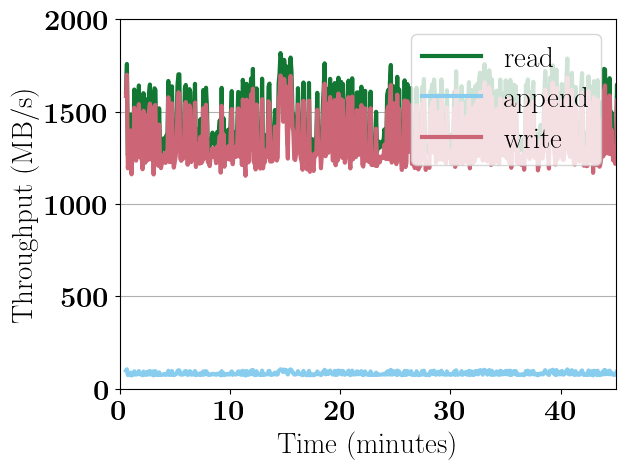

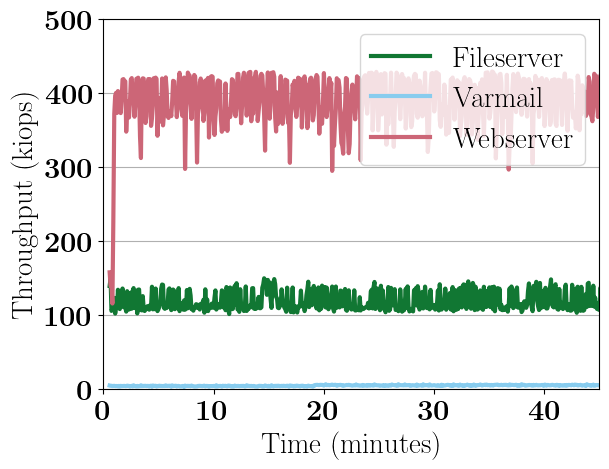

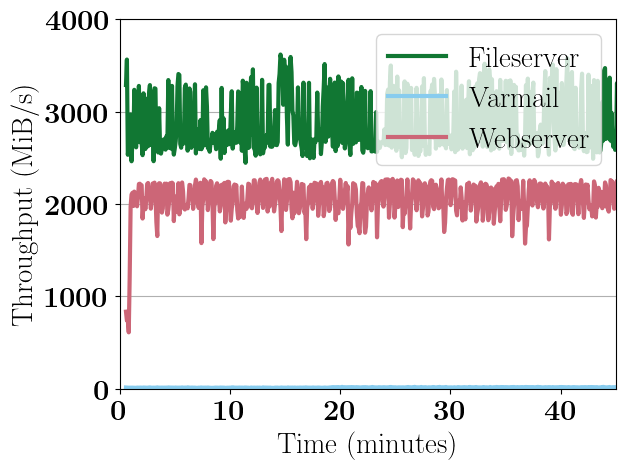

In [62]:
fig, ax = plt.subplots()

plt.ylabel("Throughput (ops)")
plt.xlabel("Time (minutes)")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 200)
plt.xlim(0, total_seconds/60)

x = [row['time']/60 for row in rows_fileserver]
y = [row['data']['readfile']['throughput_ops']/1000 for row in rows_fileserver]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=GREEN,
    fmt='-',
    label='read'
)

y = [row['data']['appendfilerand']['throughput_ops']/1000 for row in rows_fileserver]
plt.errorbar(
    x,
    y,
    linewidth=3,
    color=CYAN,
    fmt='-',
    label='append'
)

y = [row['data']['wrtfile']['throughput_ops']/1000 for row in rows_fileserver]
plt.errorbar(
    x,
    y,
    linewidth=3,
    color=ROSE,
    fmt='-',
    label='write'
)


#plt.xticks([x * 60 * 5 for x in range(5)],[x * 5 for x in range(5)])
plt.legend(loc='upper right')

#################################################################################################

fig, ax = plt.subplots()

plt.ylabel("Throughput (MB/s)")
plt.xlabel("Time (minutes)")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 2000)
plt.xlim(0, total_seconds/60)

x = [row['time']/60 for row in rows]
y = [row['data']['readfile']['throughput_bytes'] for row in rows_fileserver]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=GREEN,
    fmt='-',
    label='read'
)

y = [row['data']['appendfilerand']['throughput_bytes'] for row in rows_fileserver]
plt.errorbar(
    x,
    y,
    linewidth=3,
    color=CYAN,
    fmt='-',
    label='append'
)

y = [row['data']['wrtfile']['throughput_bytes'] for row in rows_fileserver]
plt.errorbar(
    x,
    y,
    linewidth=3,
    color=ROSE,
    fmt='-',
    label='write'
)


plt.legend(loc='upper right')

##################################################################################

fig, ax = plt.subplots()

plt.ylabel("Throughput (kiops)")
plt.xlabel("Time (minutes)")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 500)
plt.xlim(0, total_seconds/60)

x = [row['time']/60 for row in rows]
y = [row['data']['total']['throughput_ops']/1000 for row in rows_fileserver]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=GREEN,
    fmt='-',
    label='Fileserver'
)


x = [row['time']/60 for row in rows]
y = [row['data']['total']['throughput_ops']/1000 for row in rows_varmail]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=CYAN,
    fmt='-',
    label='Varmail'
)


x = [row['time']/60 for row in rows]
y = [row['data']['total']['throughput_ops']/1000 for row in rows_webserver]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=ROSE,
    fmt='-',
    label='Webserver'
)

plt.legend(loc='upper right')



##################################################################################

fig, ax = plt.subplots()

plt.ylabel("Throughput (MiB/s)")
plt.xlabel("Time (minutes)")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 4000)
plt.xlim(0, total_seconds/60)

x = [row['time']/60 for row in rows]
y = [row['data']['total']['throughput_bytes'] for row in rows_fileserver]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=GREEN,
    fmt='-',
    label='Fileserver'
)


x = [row['time']/60 for row in rows]
y = [row['data']['total']['throughput_bytes'] for row in rows_varmail]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=CYAN,
    fmt='-',
    label='Varmail'
)


x = [row['time']/60 for row in rows]
y = [row['data']['total']['throughput_bytes'] for row in rows_webserver]

plt.errorbar(
    x,
    y,
    linewidth=3,
    color=ROSE,
    fmt='-',
    label='Webserver'
)

plt.legend(loc='upper right')
